In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# Pad or truncate RNA sequence to a fixed length
def padding_sequence(seq, max_len=501, repkey='N'):
    seq_len = len(seq)
    if seq_len < max_len:
        gap_len = max_len - seq_len
        new_seq = seq + repkey * gap_len
    else:
        new_seq = seq[:max_len]
    return new_seq

# Convert RNA sequence to one-hot encoded array
def get_RNA_seq_concolutional_array(seq, motif_len=4):
    seq = seq.replace('U', 'T')
    alpha = 'ACGT'
    row = (len(seq) + 2*motif_len - 2)
    new_array = np.zeros((row, 4))

    for i in range(motif_len-1):
        new_array[i] = np.array([0.25]*4)

    for i in range(row-3, row):
        new_array[i] = np.array([0.25]*4)

    for i, val in enumerate(seq):
        i = i + motif_len-1
        if val not in 'ACGT':
            new_array[i] = np.array([0.25]*4)
            continue
        try:
            index = alpha.index(val)
            new_array[i][index] = 1
        except:
            pass
    return new_array

# Prepare data for 1-channel input to CNN
def get_bag_data_1_channel(data, max_len=501):
    bags = []
    seqs = data["seq"]
    labels = data["Y"]
    for seq in seqs:
        bag_seq = padding_sequence(seq, max_len=max_len)
        bag_subt = []
        tri_fea = get_RNA_seq_concolutional_array(bag_seq)
        bag_subt.append(tri_fea.T)
        bags.append(np.array(bag_subt))
    return bags, labels

# Read RNA sequences from a file
def read_seq_graphprot(seq_file, label=1):
    seq_list = []
    labels = []
    with open(seq_file, 'r') as fp:
        for line in fp:
            if line[0] == '>':
                name = line[1:-1]
            else:
                seq = line[:-1].upper()
                seq = seq.replace('T', 'U')
                seq_list.append(seq)
                labels.append(label)
    return seq_list, labels

# Read both positive and negative samples
def read_data_file(posifile, negafile=None, train=True):
    data = dict()
    seqs, labels = read_seq_graphprot(posifile, label=1)
    if negafile:
        seqs2, labels2 = read_seq_graphprot(negafile, label=0)
        seqs = seqs + seqs2
        labels = labels + labels2
    data["seq"] = seqs
    data["Y"] = np.array(labels)
    return data

# Prepare the final dataset
def get_data(posi, nega=None, channel=7, window_size=500, train=True):
    data = read_data_file(posi, nega, train=train)
    train_bags, label = get_bag_data_1_channel(data)
    return train_bags, label

# Load and prepare data
f, l = get_data('./CLIPSEQ_AGO2.train.positives.fa', './CLIPSEQ_AGO2.train.negatives.fa', channel=1)
f_test, l_test = get_data('./CLIPSEQ_AGO2.ls.positives.fa','CLIPSEQ_AGO2.ls.negatives.fa', channel=1, train=False)



In [3]:
# After converting the data to a numpy array
f = np.array(f)  # Shape is [92346, 107, 4, 1]
f = np.swapaxes(f, 1, 3)  # Swap the height and channel axis: New shape will be [92346, 4, 1, 107]
f = np.swapaxes(f, 2, 3)  # Final swap to correct the width position: Final shape will be [92346, 4, 107, 1]

f_test = np.array(f_test)
f_test = np.swapaxes(f_test, 1, 3)
f_test = np.swapaxes(f_test, 2, 3)

# Convert numpy arrays to PyTorch tensors
f = torch.FloatTensor(f)  # Final shape: [92346, 4, 107, 1]
l = torch.FloatTensor(l)
f_test = torch.FloatTensor(f_test)
l_test = torch.FloatTensor(l_test)

# Create DataLoader objects
train_dataset = TensorDataset(f, l)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataset = TensorDataset(f_test, l_test)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [8]:
print('f: ',f.shape)
print('l: ',l.shape)
print('f_test: ',f_test.shape)
print('l_test: ',l_test.shape)

f:  torch.Size([29686, 507, 1, 4])
l:  torch.Size([29686])
f_test:  torch.Size([1000, 507, 1, 4])
l_test:  torch.Size([1000])


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RBPBindingModel(nn.Module):
    def __init__(self):
        super(RBPBindingModel, self).__init__()
        self.conv1 = nn.Conv2d(4, 128, kernel_size=(10, 1), padding=(5, 0))
        self.dropout1 = nn.Dropout(0.25)
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 1))

        self.conv2 = nn.Conv2d(128, 128, kernel_size=(10, 1), padding=(5, 0))
        self.dropout2 = nn.Dropout(0.25)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 1))

        self.conv3 = nn.Conv2d(128, 256, kernel_size=(5, 1), padding=(2, 0))
        self.dropout3 = nn.Dropout(0.25)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(256, 128)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # x shape: (batch_size, 507, 1, 4)
        x = x.permute(0, 3, 1, 2)  # Reshape to (batch_size, 4, 507, 1)

        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.dropout3(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = torch.sigmoid(self.fc2(x))

        return x

# Instantiate the model
model = RBPBindingModel()

In [21]:
# Initialize model, loss function, and optimizer
model = RBPBindingModel()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
num_epochs = 10
train_losses = []
val_losses = []

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x).squeeze()
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered")
            break


Epoch 1/10, Train Loss: 0.6914, Val Loss: 0.6929
Epoch 2/10, Train Loss: 0.6911, Val Loss: 0.6929
Epoch 3/10, Train Loss: 0.6911, Val Loss: 0.6929
Epoch 4/10, Train Loss: 0.6908, Val Loss: 0.6929
Epoch 5/10, Train Loss: 0.6908, Val Loss: 0.6930
Early stopping triggered


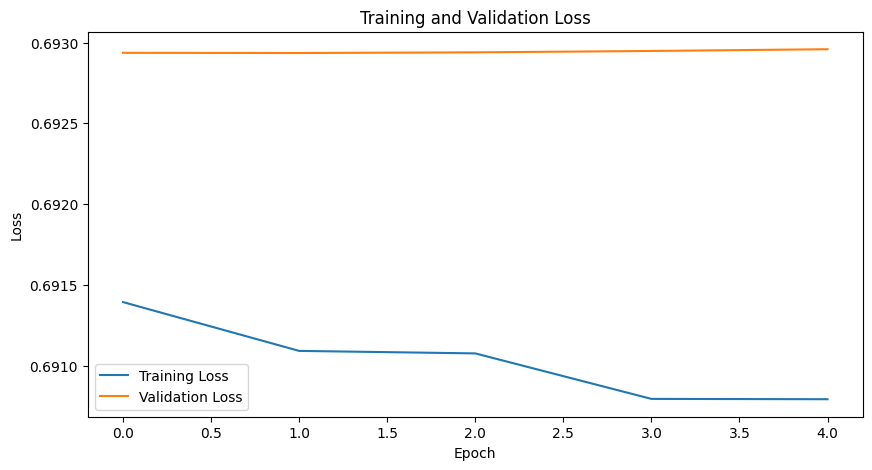

In [22]:
   # Visualize training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()